In [ ]:
!git clone https://github.com/bochendong/Car_racing.git

Cloning into 'Car_racing'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 37 (delta 13), reused 24 (delta 6), pack-reused 0
Unpacking objects: 100% (37/37), done.


# Enviorment Settings

In [ ]:
%%capture
!sudo apt update && sudo apt install python-opengl
!sudo apt update && sudo apt install xvfb
!pip install gym-notebook-wrapper stable-baselines[mpi] box2d box2d-kengz pyvirtualdisplay pyglet
!pip install wandb
!pip install pyvirtualdisplay -qq
!pip install folium==0.2.1
!apt-get install -y xvfb python-opengl ffmpeg -qq

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim

import gnwrapper
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(30)

from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import wandb

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [ ]:
!pip install box2d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Box2D-2.3.10-cp37-cp37m-manylinux1_x86_64.whl (1.3 MB)


In [ ]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [ ]:
%cd Car_racing

/content/Car_racing


In [ ]:
import car_racing as cr
import replay_memory as rm

In [ ]:
env = gnwrapper.Animation(cr.CarRacing())
env = cr.CarRacing()

obs = env.reset()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Track generation: 1001..1259 -> 258-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1059..1328 -> 269-tiles track


In [ ]:
height = width = 42

In [ ]:
obs_array = []
discrete_actions = {0 : np.array([0,0,0]),       # do nothing
                                 1 : np.array([-1,0,0]),      # steer sharp left
                                 2 : np.array([1,0,0]),       # steer sharp right
                                 3 : np.array([-0.5,0,0]),    # steer left
                                 4 : np.array([0.5,0,0]),     # steer right
                                 5 : np.array([0,1,0]),       # accelerate 100%
                                 6 : np.array([0,0.5,0]),     # accelerate 50%
                                 7 : np.array([0,0.25,0]),    # accelerate 25%
                                 8 : np.array([0,0,1]),       # brake 100%
                                 9 : np.array([0,0,0.5]),     # brake 50%
                                 10 : np.array([0,0,0.25])}   # brake 25%

n_actions = len(discrete_actions)
for i in range (0, 40):
    action = torch.randint(low=0, high=11, size=(1,))
    action_transfered = discrete_actions.get(int(action[0]))

    obs, reward, done, _ = env.step([action_transfered[0], action_transfered[1], action_transfered[2]])
    if (i % 4 == 0):
        obs_array.append(obs)

## Orginal car_racing state

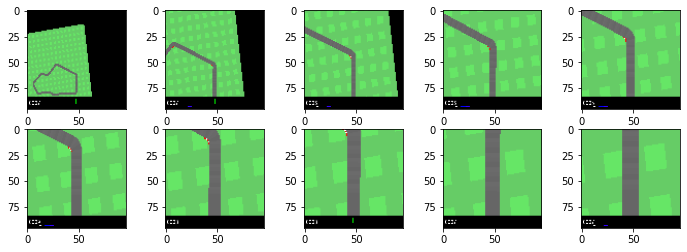

In [ ]:
f, axs = plt.subplots(2,5, figsize = (12, 4))

axs = axs.flatten()
for img, ax in zip(obs_array, axs):
    ax.imshow(img)
plt.show()

## Transfered car_racing state

In [ ]:
preprocess = T.Compose([
                    T.ToPILImage(),
                    T.Grayscale(num_output_channels=1),
                    T.Resize((height, width)),
                    T.ToTensor()])

In [ ]:
def preprocess_obs(obs):
    preprocess = T.Compose([
            T.ToPILImage(),
            T.Grayscale(num_output_channels=1),
            T.Resize((42, 42)),
            T.ToTensor()])
            
    obs = obs.reshape(96, 96, 3)
    obs = obs.transpose((2, 1, 0))

    obs = obs[:, 6:90, int(96*0):int(96 * 0.875)]
        
    obs = preprocess(torch.from_numpy(np.flip(obs, axis=0).copy()))      
        
    return obs

In [ ]:
obs_transferd_array = []

for i in range (0, 10):
    transfered_obs = preprocess_obs(obs_array[i])
    obs_transferd_array.append(transfered_obs)

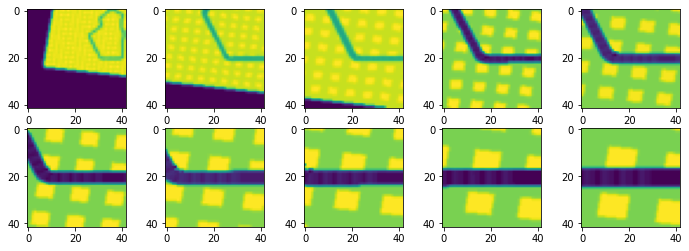

In [ ]:
to_image = T.ToPILImage()

f, axs = plt.subplots(2,5, figsize = (12, 4))

axs = axs.flatten()
for img, ax in zip(obs_transferd_array, axs):
    img = to_image(img)
    ax.imshow(img)
plt.show()

# DQN

In [ ]:
class DQN(nn.Module):
    def __init__(self, n_screens = 8, n_hidden = 512, n_outputs = 11, lr=1e-5, device='cuda'):
        super(DQN, self).__init__()
        self.device = device
        # The convolutional encoder
        self.encoder = nn.Sequential(                
                nn.Conv2d(n_screens, 64, 4, stride=2), # (1, n_screens, 42, 42) --> (1, 64, 20, 20)
                nn.BatchNorm2d(64),
                nn.MaxPool2d(2, stride = 2),                # (1, 64, 20, 20) --> (1, 64, 10, 10)
                nn.ReLU(inplace=False),
                
                nn.Conv2d(64, 128, 4, stride=2),            # (1, 64, 10, 10) --> (1, 128, 4, 4)
                nn.BatchNorm2d(128),
                nn.MaxPool2d(2, stride = 2),                # (1, 128, 4, 4) --> (1, 128, 2, 2)
                nn.ReLU(inplace=False),
                
                nn.Conv2d(128, 256, 2, stride=2),           # (1, 128, 2, 2) --> (1, 256, 1, 1)
                nn.ReLU(inplace=False),
                
                ).to(self.device)
        
        # The size of the encoder output
        encoder_output_shape = (256, 1, 1) 
        encoder_output_size = np.prod(encoder_output_shape)
        
        self.fc1 = nn.Linear(encoder_output_size, n_hidden) # Hidden layer
        self.fc2 = nn.Linear(n_hidden, n_outputs)           # Output layer
        
        self.optimizer = optim.Adam(self.parameters(), lr)            # Adam optimizer
        
        self.to(self.device)

    def forward(self, x):
        # cast to device
        x = x.to(self.device)
        
        h1 = self.encoder(x)
        
        h2 = F.relu(self.fc1(h1.view(h1.size(0), -1)))
        
        y  = self.fc2(h2)
        
        return y

# Agent

In [ ]:
gamma = 0.99
device = 'cuda'
batch_size = 250

In [ ]:
class Agent():
    def __init__(self, policy_net, target_net, n_screens = 8):
        self.n_screens = n_screens            # number of observations stacked
        self.freeze_cntr = 0           # Keeps track of when to (un)freeze the target network
        self.policy_net = policy_net
        self.target_net = target_net
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.memory = rm.ReplayMemory(300000, (42, 42), height * width, False, device=device)
        
        # Initialize last observations array (shape (8, 42, 42) )
        self.obs_batch = np.array([np.zeros((height, width), dtype = 'float32') for i in range(self.n_screens)])
    
        # When sampling from memory at index i, obs_indices indicates that we want observations with indices i-obs_indices, works the same for the others
        # [9, 8, 7, 6, 5 ,4, 3, 2, 1, 0]
        self.obs_indices = [(n_screens+1)-i for i in range(n_screens+2)]
        self.action_indices = [1]
        self.reward_indices = [1]
        self.done_indices = [0]
        # 10
        self.max_n_indices = max(max(self.obs_indices, self.action_indices, self.reward_indices, self.done_indices)) + 1
        

    def select_action(self, obs, eps):
        if np.random.rand() <= eps:
            return torch.randint(low=0, high= 11, size=(1,)).to(device)
        else:
            with torch.no_grad():
                action_values = self.policy_net(obs).to(device)
                return torch.tensor([torch.argmax(action_values)], dtype=torch.int64, device=device)

    """ stack the X latest observations into one batch """
    def get_obs_batch(self, obs):
        # add new observation to obs_batch, remove oldest.
        self.obs_batch = np.concatenate((obs.numpy(), self.obs_batch[0:self.n_screens-1]), axis = 0)
        
        # resize to (1, self.n_screens, 42, 42) and convert to torch
        obs_batch2 = torch.from_numpy(np.flip(self.obs_batch, axis=0).copy()).unsqueeze(0).to(device)
        return obs_batch2
    

    def learn(self, freeze_period = 50, gamma = 0.99):
        if self.memory.push_count - self.max_n_indices*2 < batch_size:
            return
        
        if self.freeze_cntr % freeze_period == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        self.freeze_cntr += 1
        
        # Retrieve transition data in batches
        all_obs_batch, action_batch, reward_batch, done_batch = self.memory.sample(
                self.obs_indices, self.action_indices, self.reward_indices, self.done_indices, self.max_n_indices, batch_size)
  
        # Retrieve a batch of observations for 2 consecutive points in tim
        obs_batch = all_obs_batch[:, 0:self.n_screens, :, :].view(batch_size, self.n_screens, height, width)
        next_obs_batch = all_obs_batch[:, 1:self.n_screens+1, :, :].view(batch_size, self.n_screens, height, width)
        
        # Get the q values and the target values, then determine the loss
        value_batch = self.policy_net(obs_batch).gather(1, action_batch).to(device)
        target_out = self.target_net(next_obs_batch).to(device)
        target_batch = reward_batch + (1-done_batch) * gamma * target_out.max(1)[0].view(batch_size, 1)
        loss = F.mse_loss(target_batch, value_batch)
        
        self.policy_net.optimizer.zero_grad()
        loss.backward()
        self.policy_net.optimizer.step()
    
    def train(self, env, episodes, eps_settings):
        results = []
        eps, eps_max, eps_min, eps_decay = eps_settings
        max_epiosde_length = 1000
        
        for ith_episode in range(episodes):
            reward, total_reward = 0, 0
            nr_steps = 0
            done = False
            
            obs = env.reset()
            obs = preprocess_obs(obs)
            obs_batch = self.get_obs_batch(obs)
            
            while not done and nr_steps <= max_epiosde_length:
                action = self.select_action(obs_batch, eps)
                
                self.memory.push(obs, action, reward, done)
                
                action_todo = discrete_actions.get(int(action[0]))
                
                obs, reward, done, _ = env.step([action_todo[0], action_todo[1], action_todo[2]])
                nr_steps = nr_steps + 1
                
                obs = preprocess_obs(obs)
                obs_batch = self.get_obs_batch(obs)
                
                total_reward += reward
                
                self.learn()
                
                # check if episode is done
                if done or nr_steps == max_epiosde_length:
                    self.memory.push(obs, -99, -99, True)
            
            results.append(total_reward)
            
            avg_reward = np.mean(results)
            print("e: %d, reward: %.2f" % (ith_episode, avg_reward))
            if eps > eps_min:
                eps = eps_max - (ith_episode * eps_decay)
            
        # close environment after training
        env.close()

    def play(self, env, render = False):
        rewards = []

        for ith_episode in range(10):
            total_reward = 0
            nr_steps = 0

            obs = env.reset()
            obs = preprocess_obs(obs)
            obs_batch = self.get_obs_batch(obs)
            done = False
            
            while not done and nr_steps <= 1000:
                action = self.select_action(obs_batch)
                
                action_todo = discrete_actions.get(int(action[0]))
                
                obs, reward, done, _ = env.step([action_todo[0], action_todo[1], action_todo[2]])
                nr_steps = nr_steps + 1

                obs = preprocess_obs(obs)
                obs_batch = self.get_obs_batch(obs)
                

                if render:
                    env.render('human')
                
                # add reward to total
                total_reward += reward

            rewards.append(total_reward)
            print("Reward for this episode:", total_reward)
            total_reward = 0         

        env.close()
        return rewards


In [ ]:
n_screens = 8
n_hidden = 512
n_outputs = 11
learning_rate = 1e-5

In [ ]:
# Create networks
policy_net = DQN(n_screens = n_screens, n_hidden = n_hidden, n_outputs=n_actions, lr=learning_rate, device=device)
target_net = DQN(n_screens = n_screens, n_hidden = n_hidden, n_outputs=n_actions, lr=learning_rate, device=device)

In [ ]:
agent = Agent(policy_net=policy_net, target_net=target_net, n_screens=n_screens)
agent.train(env=env,  episodes = 1000, eps_settings = (0.15, 0.15, 0.05, 0.00015))

Track generation: 1039..1303 -> 264-tiles track
e: 0, reward: -75.75
Track generation: 1271..1593 -> 322-tiles track
e: 1, reward: -61.45
Track generation: 972..1216 -> 244-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1125..1417 -> 292-tiles track
e: 2, reward: -18.20
Track generation: 1131..1418 -> 287-tiles track


In [ ]:
torch.save(policy_net.state_dict(), './policy_net.pth')

In [ ]:
torch.save(target_net.state_dict(), './target_net.pth')

# Play

In [ ]:
results = agent.play(env=env)